In [1]:
import numpy as np
import librosa
import tensorflow as tf
import os

import IPython.display as ipd
from data import get_features
from model import get_model

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.gridspec import GridSpec
%matplotlib notebook

c:\soft\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
FFT_SIZE = 512
FRAME_SIZE = FFT_SIZE # 32ms for SR = 16kHz
FRAME_OFFSET =  128 # 8ms for SR = 16kHz

N_HARM = 14
N_CAND = 100
SEQ_LEN = 16
BATCH_SIZE = 1
N_HIDDEN = 16
PADDING = 'SAME'

SR = 16000
RNN_STRIDE = 1

In [5]:
# file_path = 'D:\\VAD-dataset\\Examples\\_79854766371-2018.01.28_18-40_.wav'
file_path = 'test_seq_noise_16kHz.wav'

In [6]:
y, _ = librosa.load(file_path, sr=SR)
ipd.Audio(y, rate=SR)

In [7]:
features = get_features(signal=y, n_cand=N_CAND)

In [8]:
def batch_iterator(features):
    padded_features = np.pad(features, ((SEQ_LEN, 0), (0, 0), (0, 0)), mode='constant', constant_values=0).astype(np.float32)
    n_samples = padded_features.shape[0] - SEQ_LEN + 1

    for i in range(n_samples):
        batch_features = padded_features[i:i+SEQ_LEN]
        batch_features = batch_features[np.newaxis, ...]
        yield batch_features

In [9]:
ckpt = tf.train.get_checkpoint_state('trained_model/base')
path_to_model = os.path.join('trained_model/base', 'model.ckpt-499999')

In [10]:
mean_std = np.load('mean-std.npz')

# mean = np.mean(mean_std['mean'][np.newaxis, np.newaxis, ...], axis=2, keepdims=True)
# std = np.std(mean_std['std'][np.newaxis, np.newaxis, ...], axis=2, keepdims=True)

mean = mean_std['mean'][np.newaxis, np.newaxis, ...]
std = mean_std['std'][np.newaxis, np.newaxis, ...]
mean = tf.constant(mean, name='mean')
std = tf.constant(std, name='std')

In [11]:
model = {}
model['N_HIDDEN'] = N_HIDDEN
model['N_CAND'] = N_CAND
model['SEQ_LEN'] = SEQ_LEN
model['BATCH_SIZE'] = BATCH_SIZE
model['RNN_STRIDE'] = RNN_STRIDE
model['PADDING'] = PADDING

In [12]:
features_phr = tf.placeholder(tf.float32, [None, SEQ_LEN, N_CAND, N_HARM], name='inputs/features')
(rnn_preds, cnn_preds), (rnn_acts, cnn_acts) = get_model(features_phr, model, mean, std, is_training=False, return_activations=True)
saver = tf.train.Saver()

sess = tf.Session()
saver.restore(sess, path_to_model)

INFO:tensorflow:Restoring parameters from trained_model/base\model.ckpt-499999


In [13]:
batch = batch_iterator(features)

results = []

for batch_features in batch:
    result = sess.run([rnn_preds, cnn_preds, rnn_acts, cnn_acts], 
                      feed_dict={features_phr: batch_features})
    results.append(result)

In [14]:
_rnn_output, _cnn_output, _rnn_activation, _cnn_actuvation = zip(*results)

In [15]:
_cnn_actuvation = np.array(_cnn_actuvation).reshape(-1, N_CAND, 1)
_rnn_activation = np.array(_rnn_activation).reshape(-1, 100, 1)
_cnn_output = np.array(_cnn_output)[..., 0]
_rnn_output = np.array(_rnn_output)

In [16]:
cnn_predictions = _cnn_output.reshape((-1, ))
rnn_predictions = _rnn_output.reshape((-1, ))

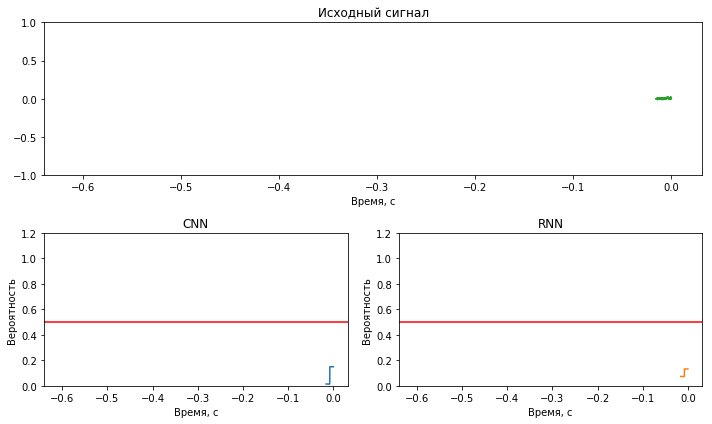

In [17]:
n_frames = 40
scale = 2
x = np.arange(-FRAME_OFFSET * scale * n_frames, 0) / SR
signal_frames = [None] * n_frames * scale * FRAME_OFFSET
cnn_pred_frames = [None] * n_frames * scale * FRAME_OFFSET
rnn_pred_frames = [None] * n_frames * scale * FRAME_OFFSET

fig = plt.figure(figsize=(10, 6))
gs = GridSpec(2, 2)

plt.subplot(gs[0, :])
signal_line, = plt.plot(x, signal_frames, color='tab:green')
plt.title('Исходный сигнал')
plt.xlim(-len(x) / SR, 500 / SR)
plt.ylim(-1, 1)
plt.xlabel('Время, c')

plt.subplot(gs[1, 0])
plt.plot([-len(x) / SR, 500 / SR], [0.5, 0.5], 'r')
cnn_line, = plt.plot(x, cnn_pred_frames, color='tab:blue')
plt.xlim(-len(x) / SR, 500 / SR)
plt.ylim(0, 1.2)
plt.title('CNN')
plt.xlabel('Время, c')
plt.ylabel('Вероятность')

plt.subplot(gs[1, 1])
plt.title('RNN')
plt.plot([-len(x) / SR, 500 / SR], [0.5, 0.5], 'r')
rnn_line, = plt.plot(x, rnn_pred_frames, color='tab:orange')
plt.xlim(-len(x) / SR, 500 / SR)
plt.ylim(0, 1.2)
plt.xlabel('Время, c')
plt.ylabel('Вероятность')

plt.tight_layout()

def animate(i):
    global signal_frames
    frame_data = y[(i-1)*scale * FRAME_OFFSET:i * scale * FRAME_OFFSET]
    signal_frames += frame_data.tolist()
    del signal_frames[:scale * FRAME_OFFSET]
    signal_line.set_data(x, signal_frames)
    
    global cnn_pred_frames
    frame_data = cnn_predictions[(i-1)*scale:i*scale]
    frame_data = frame_data.tolist()
    for item in frame_data:
        cnn_pred_frames += [item] * FRAME_OFFSET
    del cnn_pred_frames[:scale * FRAME_OFFSET]
    cnn_line.set_data(x, cnn_pred_frames)
    
    
    global rnn_pred_frames
    frame_data = rnn_predictions[(i-1)*scale:i*scale]
    frame_data = frame_data.tolist()
    for item in frame_data:
        rnn_pred_frames += [item] * FRAME_OFFSET
    del rnn_pred_frames[:scale * FRAME_OFFSET]
    rnn_line.set_data(x, rnn_pred_frames)
    
    return [signal_line, cnn_line, rnn_line]

anim = animation.FuncAnimation(fig, animate, frames=range(1, features.shape[0] // scale + 1), interval=scale * 8, blit=True)

In [18]:
anim.save('test.mp4', writer='ffmpeg')